<a href="https://colab.research.google.com/github/enerdb/Hands_on_Book/blob/main/Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST
MNIST dataset has 70000 images of digits. This code aims at classifing these images.

In [1]:
%matplotlib inline
from sklearn.datasets import fetch_openml

import numpy as np

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()
X, y = mnist['data'].values, mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


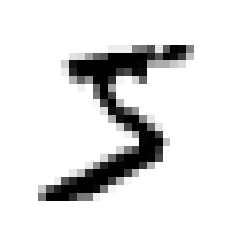

'5'

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

digit0 = X[0]
digit0_image = digit0.reshape(28,28)

plt.imshow(digit0_image, cmap='binary')
plt.axis('off')
plt.show()
y[0]

In [4]:


y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier


Creating a 5-detector

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
sgd_clf.predict([digit0])


array([ True])

## Performance Measures


In [8]:
# Implementing Cross-Validation
# This code does the same as sklearn's cross_val_score()
# from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)#, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


This dumb classifier always predicts not 5 and has 90% accuracy because only 10% of the dataset is made of 5s:

In [9]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class Never5Classifier(BaseEstimator):

    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [10]:
from sklearn.model_selection import cross_val_predict

# returns predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 


In [11]:
y_train_pred


array([ True, False, False, ...,  True, False, False])

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric.

Precision = TP / (TP+FP)

Recall = Sensitivity = True Positive Rate (TPR) = TP / (TP+FN)


In [13]:
from sklearn.metrics import precision_score, recall_score

print('precision: ', precision_score(y_train_5, y_train_pred))
print('recall: ', recall_score(y_train_5, y_train_pred))


precision:  0.8370879772350012
recall:  0.6511713705958311


F1 score is the harmonic mean of precision and recall

In [14]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

### Precision/Recall Trade-off


In [15]:
y_scores = sgd_clf.decision_function([digit0])
y_scores

array([2164.22030239])

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [17]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)



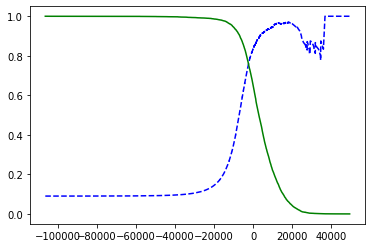

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    #[...] # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

To aim at a fixed precision target

In [19]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 

In [20]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [21]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [22]:
recall_score(y_train_5, y_train_pred_90)


0.4799852425751706

## The ROC Curve

The ROC Curve plotsthe True positive rate (TPR = recall) against the false positive rate (FPR).

TNR = True negative rate = specificity

FPR = 1 - TNR 


In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


No handles with labels found to put in legend.


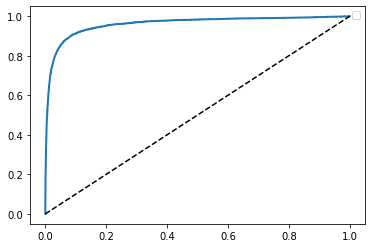

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    # plt.legend()
    # [...] # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

We will train a Random Forest Classifier to compare the results with SGD.

Random Forests do not have decision_function() method. It uses predict_proba() instead.

In this case, we can pass class probabilities instead.

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [27]:
y_scores_forest = y_probas_forest[:, 1] # proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


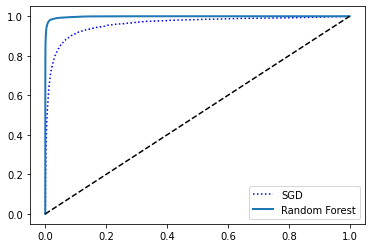

In [29]:
plt.plot(fpr,tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145

In [ ]:
forest_clf.fit(X_train, y_train_5)
y_forest_test = forest_clf.predict(X_test)



In [36]:
y_forest_test.shape

(10000,)

In [37]:
print('precision: ', precision_score(y_test_5, y_forest_test))
print('recall: ', recall_score(y_test_5, y_forest_test))

precision:  0.993581514762516
recall:  0.8677130044843049


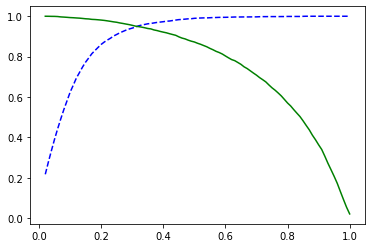

In [32]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# Multiclass Classification


In [38]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([digit0])


array([5], dtype=uint8)

In [39]:
digit0_scores = svm_clf.decision_function([digit0])
digit0_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

If you want to use a OneVsOneClassifier or OneVsRestClassifier:

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([digit0])


In [ ]:
len(ovr_clf.estimators_)


In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

# Error Analysis

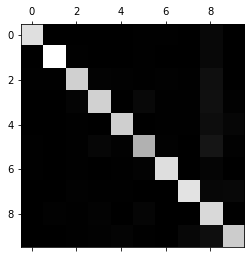

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


First, it is important to divide each value by the number of images  in the corresponding class, so we compare the rates, not absolute numbers.

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors.


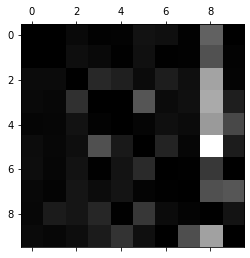

In [48]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


# Multilabel Classification

In [45]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)



KNeighborsClassifier()